pandas-ylt
==========

Python modules for working in pandas with various loss data tables used for CAT modelling


### Read the example YLT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas_ylt.yeareventloss import YearEventLossTable
from pandas_ylt.yeareventallocloss import YearEventAllocLossTable
# Define the layers
from pandas_ylt.layer import Layer


yelt = pd.read_csv("tests/_data/example_pareto_poisson_yelt.csv",
                    index_col=['Year', 'EventID', 'DayOfYear'])['Loss']
yelt.attrs['n_yrs'] = 1e5

display(yelt.yel.to_rp_summaries([1000, 200, 100, 10], is_ef=False).to_frame().style.format("{:,.0f}"))
display(yelt.yel.to_summary_stats_series().to_frame().style.format("{:,.0f}"))

,Loss
Metric,
AAL,"5,564"
STD,"158,881"


### Applying an example reinsurance tower to the losses

In [2]:
layers = {
    # Layers at 20,000 increments with 1 reinstatement
    "20 xs 20 (1@100)": Layer(
        **{"limit": 20000, "xs": 20000, "agg_limit": 40000.0, "reinst_rate": 0.1, "premium": 2000}
    ),
    "20 xs 40 (1@100)": Layer(
        **{"limit": 20000, "xs": 40000, "agg_limit": 40000.0, "reinst_rate": 0.05, "premium": 1000}
    ),
    "20 xs 60 (1@100)": Layer(
        **{"limit": 20000, "xs": 60000, "agg_limit": 40000.0, "reinst_rate": 0.02, 'premium': 400}
    ),
    "20 xs 80 (1@0)": Layer(
        **{"limit": 20000, "xs": 80000, "agg_limit": 40000.0, "reinst_rate": 0.0, "premium": 400}
    ),
}

Get the summary stats for each layer

In [3]:
# Get a separate YLT for each layer
lyr_yelts = {lyr: layers[lyr].yelt_loss(yelt) for lyr in layers}
# lyr_yelts

# Calculate the layer stats from the YLTs
summary_stats = {k: 
 {'AAL': yelt.yel.aal, 
  'STD': yelt.yel.to_ylt().yl.std(),
  'ExpReinst': yelt.yel.to_ylt().clip(upper=(layers[k].max_reinstated_limit)).yl.aal * layers[k].reinst_rate,
  'AttachRP': 1 / yelt.yel.to_ylt().yl.prob_of_a_loss,
  'FullLimitRP': 1 / yelt.yel.to_ylt(is_occurrence=True).yl.loss_exprobs([layers[k].limit])[0],
  'ExhaustRP': 1 / yelt.yel.to_ylt().yl.loss_exprobs([layers[k].agg_limit])[0],
 }
  for k, yelt in lyr_yelts.items()}

# Display the results
pd.DataFrame(summary_stats).T.style.format({"AAL": "{:,.0f}", 'STD': '{:,.0f}', 
                                            'ExpReinst': '{:.1f}', 
                                            'AttachRP': "{:,.0f}",
                                            'FullLimitRP': "{:,.0f}",
                                            'ExhaustRP': "{:,.0f}",            
                                            })

/tmp/ipykernel_6410/1661765216.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  'ExhaustRP': 1 / yelt.yel.to_ylt().yl.loss_exprobs([layers[k].agg_limit])[0],


,AAL,STD,ExpReinst,AttachRP,FullLimitRP,ExhaustRP
20 xs 20 (1@100),336,"2,439",33.4,41,82,"16,667"
20 xs 40 (1@100),201,"1,934",10.0,82,121,"50,000"
20 xs 60 (1@100),144,"1,656",2.9,121,161,"100,000"
20 xs 80 (1@0),114,"1,482",0.0,161,196,inf


Calculate the YLTs net of reinstatement costs. The AAL to the layer is reduced because reinst premiums offset the loss.

In [4]:
lyr_yelts_net_rip = {lyr: layers[lyr].yelt_loss(yelt, net_reinst=True) for lyr in layers}
summary_stats = {k: 
 {'AAL': yelt.yel.aal, 
  'STD': yelt.yel.to_ylt().yl.std(),
 }
  for k, yelt in lyr_yelts_net_rip.items()}

# Display the results
pd.DataFrame(summary_stats).T.style.format({"AAL": "{:,.0f}", 'STD': '{:,.0f}',})

,AAL,STD
20 xs 20 (1@100),303,"2,198"
20 xs 40 (1@100),191,"1,838"
20 xs 60 (1@100),141,"1,623"
20 xs 80 (1@0),114,"1,482"


Get the net and final net EP curve

In [5]:
retained_yelt = yelt.subtract(pd.concat(lyr_yelts.values()).groupby(yelt.index.names).sum(), fill_value=0.0)
net_rip_yelt = yelt.subtract(pd.concat(lyr_yelts_net_rip.values()).groupby(yelt.index.names).sum(), fill_value=0.0)

combined_rp_curves = pd.concat([
    df.yel.to_rp_summary([250, 200, 150, 100, 75, 50, 25, 10], is_ep=True, is_occurrence=True).rename(name)
    for name, df in [('Gross', yelt), ('Net', retained_yelt), ('Final Net', net_rip_yelt)]
], axis=1)


display(combined_rp_curves.style.format("{:,.0f}"))
# display(retained_yelt.yel.to_summary_stats_series().to_frame().style.format("{:,.0f}"))

,Gross,Net,Final Net
ReturnPeriod,,,
250,"123,967","43,967","47,367"
200,"101,450","21,450","24,850"
150,"75,760","20,000","23,311"
100,"49,340","20,000","22,449"
75,"36,257","20,000","21,616"
50,"24,074","20,000","20,407"
25,"12,135","12,135","12,135"
10,"4,708","4,708","4,708"


Plot the OEP

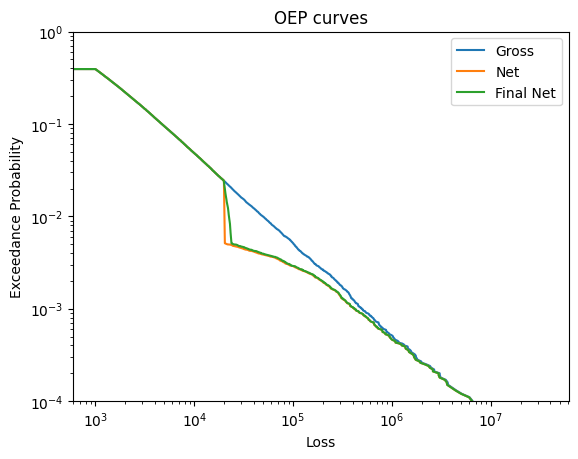

In [6]:
# Make a plot
fig, ax = plt.subplots(1)

for name, df in [('Gross', yelt), ('Net', retained_yelt), ('Final Net', net_rip_yelt)]:
    df.yel.to_ylt(is_occurrence=True).yl.to_ep_curve().plot('Loss', 'ExProb', ax=ax, label=name)

ax.set(xscale='log', yscale='log', ylim=[1e-4, 1], ylabel='Exceedance Probability')
plt.title('OEP curves')
plt.show()

Plot AEP

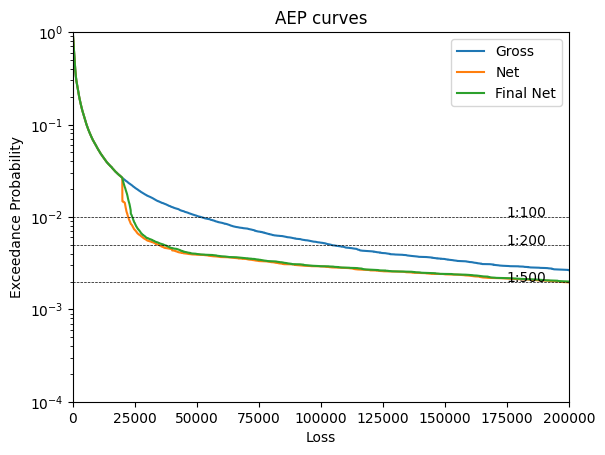

In [7]:
# Make a plot
fig, ax = plt.subplots(1)

for name, df in [('Gross', yelt), ('Net', retained_yelt), ('Final Net', net_rip_yelt)]:
    df.yel.to_ylt().yl.to_ep_curve().plot('Loss', 'ExProb', ax=ax, label=name)

for rp in [100, 200, 500]:
    ax.plot(ax.get_xlim(), [1/rp, 1/rp], '--k', linewidth=0.5)
    ax.text(1.75e5, 1/rp, f"1:{rp}")

ax.set( yscale='log', ylim=[1e-4, 1], xlim=[0, 0.2e6], ylabel='Exceedance Probability')
plt.title('AEP curves')
plt.show()

### Some example numbers to show the impact on the cost of capital

In [8]:
total_capital = 200e3
capital_cost_rate = 0.08
capital_needed_from = yelt.yel.to_ylt().yl.loss_at_exprobs([0.5])[0]
cost_of_reins = sum([x.premium for x in layers.values()])

# Base case with no reinsurance
print("No reinsurance.")
print(f"\tCost of capital = {capital_cost_rate * total_capital:,.0f}")

peak_loss = total_capital + capital_needed_from
print("\tReturn period for peak loss = " + 
      f"{1 / yelt.yel.to_ylt().yl.loss_exprobs([peak_loss])[0]:,.0f}")

capital_buffer = peak_loss - yelt.yel.to_ylt().yl.loss_at_exprobs([1/200])[0]
print("\tRemainder at 1:200 = " + 
      f"{capital_buffer:,.0f}")

# How reinsuance changes the numbers
print("Reinsurance + same capital.")
print(f"\tCost of reins = {cost_of_reins:,.0f}")
print(f"\tCost of capital = {capital_cost_rate * (total_capital - cost_of_reins):,.0f}")
print("\tReturn period for peak loss = " + 
      f"{1 / net_rip_yelt.yel.to_ylt().yl.loss_exprobs([peak_loss - cost_of_reins])[0]:,.0f}")
print("\tRemainder at 1:200 = " + 
      f"{peak_loss - net_rip_yelt.yel.to_ylt().yl.loss_at_exprobs([1/200])[0]:,.0f}")

# If reinsurance is used instead of capital
print("Reinsurance offsetting capital.")
print(f"\tCost of reins = {cost_of_reins:,.0f}")

new_capital = capital_buffer
new_peak_loss = net_rip_yelt.yel.to_ylt().yl.loss_at_exprobs([1/200])[0] + capital_buffer

print(f"\tCost of capital = {capital_cost_rate * new_capital:,.0f}")

print("\tReturn period for peak loss = " + 
      f"{1 / net_rip_yelt.yel.to_ylt().yl.loss_exprobs([new_peak_loss])[0]:,.0f}")
print("\tRemainder at 1:200 = " + 
      f"{new_peak_loss - net_rip_yelt.yel.to_ylt().yl.loss_at_exprobs([1/200])[0]:,.0f}")


No reinsurance.
	Cost of capital = 16,000
	Return period for peak loss = 379
	Remainder at 1:200 = 95,982
Reinsurance + same capital.
	Cost of reins = 3,800
	Cost of capital = 15,696
	Return period for peak loss = 498
	Remainder at 1:200 = 163,301
Reinsurance offsetting capital.
	Cost of reins = 3,800
	Cost of capital = 7,679
	Return period for peak loss = 391
	Remainder at 1:200 = 95,982


### Define some layers

In [9]:



layers = [
    # First loss
    {'name': '20 xs 0', 'layer': Layer(**{'limit': 20000, 'xs': 0, 'agg_limit': 20000.0})},    
    {'name': '20 xs 20', 'layer': Layer(**{'limit': 20000, 'xs': 20000, 'agg_limit': 20000.0})},
    {'name': '20 xs 40', 'layer': Layer(**{'limit': 20000, 'xs': 40000, 'agg_limit': 20000.0})},
    {'name': '20 xs 60', 'layer': Layer(**{'limit': 20000, 'xs': 60000, 'agg_limit': 20000.0})},    
    {'name': '20 xs 80', 'layer': Layer(**{'limit': 20000, 'xs': 80000, 'agg_limit': 20000.0})},    
    # Second loss
    {'name': '20 xs 0 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 0, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},        
    {'name': '20 xs 20 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 20000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},
    {'name': '20 xs 40 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 40000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})},
    {'name': '20 xs 60 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 60000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})}, 
    {'name': '20 xs 80 reinst', 'layer': Layer(**{'limit': 20000, 'xs': 80000, 'agg_limit': 20000.0, 'agg_xs': 20000.0})}, 
]

